In [376]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd

- get the 3-letter abbreviation of each team
- the url to access 2021 season for each team is https://www.basketball-reference.com/teams/ + team_abbrev + /2021.html

In [377]:
html = urlopen('https://www.basketball-reference.com/teams/')
html_read = html.read()
bsObj = BeautifulSoup(html_read)

team_abbrev = []
for child in bsObj.find('tbody').children:
    try:
        team_url = child.find('a').get('href')
        team = re.split('/', team_url)[2]
        team_abbrev.append(team)
    except:
        pass
    
df_teams = pd.DataFrame(team_abbrev, columns=['team'])

# fix abbreviation for teams with new abbreviations in 2021 season
df_teams.iloc[2] = 'BRK'
df_teams.iloc[18] = 'NOP'
df_teams.iloc[3] = 'CHO'

- get the player code for each team
- create a df with columns for team and player code

In [378]:
df_players = pd.DataFrame(columns = ['team', 'player'])
codes = []
for team in df_teams['team']:
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021.html')
    bsObj = BeautifulSoup(team_url.read())
    for child in bsObj.find('tbody').children:
        try:
            player_url = child.find('a').get('href')
            player_url = re.split('\.', player_url)[0]
            player_code = re.split('/', player_url)[3]
            player_code = '/' + player_code[0] + '/' + player_code
            codes.append(player_code)
        except:
            pass
    df_team = pd.DataFrame(zip([team] * len(codes), codes), columns=['team', 'player'])
    df_players = pd.concat([df_players, df_team], join='outer')
    codes = []

df_players = df_players.reset_index(drop=True)

# brazdig01 is repeated twice so delete one of them (also the link doesnt work so delete both)
df_players.drop(labels=371, inplace=True)
df_players.drop(labels=372, inplace=True)

# Game stats for each player
### needs to be updated daily

In [297]:
stat_names = ['player','date','team','home','opp','min','FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST',
         'STL','BLK','TOV','PF','PTS','GmSc','+/-']
df_stats = pd.DataFrame(columns=stat_names)
for i, player in enumerate(df_players['player']):
    if i % 50 == 0:
        print('{}% complete'.format(round(100*i/len(df_players))))
    player_url = urlopen('https://www.basketball-reference.com/players/' + player + '/gamelog/2021')
    bsObj = BeautifulSoup(player_url.read())
    stats = []
    for child in bsObj.find('tbody').children:
        try:
            stats.append(player)
            for child1 in child.children:
                stats.append(child1.get_text())
        except:
            pass   
        # if len(stats) < 31, the player did not play that night so ignore those rows
        if len(stats) == 31:
            # get rid of unnecessary columns
            del stats[1:3]
            del stats[2]
            del stats[5:7]
            del stats[8]
            del stats[10]
            del stats[12]
            df_stats = df_stats.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns=stat_names))
        stats = []
df_stats = df_stats.reset_index(drop=True)
df_stats.to_csv('df_stats.csv')
df_stats.head()

0% complete
10% complete
20% complete
30% complete
40% complete
49% complete
59% complete
69% complete
79% complete
89% complete
99% complete


,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,@,CHI,28:24,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8
1,/h/hillso01,2020-12-26,ATL,@,MEM,12:58,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,+3
2,/h/hillso01,2020-12-28,ATL,,DET,19:55,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,+14
3,/h/hillso01,2020-12-30,ATL,@,BRK,16:43,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9
4,/h/hillso01,2021-01-01,ATL,@,BRK,23:40,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,+20


# Cleaning

In [379]:
df_stats = pd.read_csv('df_stats.csv')
df_stats.drop(columns='Unnamed: 0', axis=1, inplace=True)
df_stats.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,@,CHI,28:24,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8.0
1,/h/hillso01,2020-12-26,ATL,@,MEM,12:58,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,3.0
2,/h/hillso01,2020-12-28,ATL,NaN,DET,19:55,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,14.0
3,/h/hillso01,2020-12-30,ATL,@,BRK,16:43,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9.0
4,/h/hillso01,2021-01-01,ATL,@,BRK,23:40,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,20.0


In [380]:
# for home column, 1 means home game, 0 means road game
df_stats['home'] = np.where(df_stats['home']=='@', 1, 0)
df_stats.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,1,CHI,28:24,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8.0
1,/h/hillso01,2020-12-26,ATL,1,MEM,12:58,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,3.0
2,/h/hillso01,2020-12-28,ATL,0,DET,19:55,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,14.0
3,/h/hillso01,2020-12-30,ATL,1,BRK,16:43,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9.0
4,/h/hillso01,2021-01-01,ATL,1,BRK,23:40,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,20.0


In [381]:
# change min column to numeric
def min_to_numeric(value):
    minute = int(re.split(':', value)[0])
    second = int(re.split(':', value)[1])
    return minute + round(second / 60, 2)
df_stats['min'] = df_stats['min'].apply(lambda x: min_to_numeric(x))
df_stats.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,1,CHI,28.40,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8.0
1,/h/hillso01,2020-12-26,ATL,1,MEM,12.97,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,3.0
2,/h/hillso01,2020-12-28,ATL,0,DET,19.92,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,14.0
3,/h/hillso01,2020-12-30,ATL,1,BRK,16.72,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9.0
4,/h/hillso01,2021-01-01,ATL,1,BRK,23.67,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,20.0


In [383]:
# two null values in +/- column
label_1, label_2 = df_stats[df_stats['+/-'].isnull()].iloc[0].name, df_stats[df_stats['+/-'].isnull()].iloc[1].name
# first one: all values are 0 so drop this columns
df_stats.drop(labels=[label_1], axis=0, inplace=True)
# second one: I looked it up on espn and the value should be -4
df_stats.loc[label_2,'+/-'] = '-4'

In [384]:
df_stats['date'] = pd.to_datetime(df_stats['date'])
df_stats.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,1,CHI,28.40,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8
1,/h/hillso01,2020-12-26,ATL,1,MEM,12.97,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,3
2,/h/hillso01,2020-12-28,ATL,0,DET,19.92,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,14
3,/h/hillso01,2020-12-30,ATL,1,BRK,16.72,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9
4,/h/hillso01,2021-01-01,ATL,1,BRK,23.67,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,20


In [385]:
# convert relevant columns to numeric type
numeric_stats = ['FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','GmSc','+/-']
for stat in numeric_stats:
    df_stats[stat] = pd.to_numeric(df_stats[stat])

# Team Stats

In [386]:
team_stats_names = ['date','home','Opp','W/L','score','score_Opp','FG','FGA','3P','3PA','FT','FTA','ORB','TRB','AST',
                    'STL','BLK','TOV','PF','FG_Opp','FGA_Opp','3P_Opp','3PA_Opp','FT_Opp','FTA_Opp','ORB_Opp',
                    'TRB_Opp','AST_Opp','STL_Opp','BLK_Opp','TOV_Opp','PF_Opp'
                   ]
teams_gamelog = {team: pd.DataFrame(columns=team_stats_names) for team in df_teams['team']}
for team in df_teams['team']:
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021/gamelog/')
    bsObj = BeautifulSoup(team_url.read())
    stats = []
    for child in bsObj.find('tbody').children:
        try:
            for child1 in child.children:
                stats.append(child1.get_text())
        except:
            pass 
        if len(stats) == 41:
            unnecessary_indices = [33,30,27,24,16,13,10,1,0]
            for i in unnecessary_indices:
                del stats[i]
            teams_gamelog[team] = teams_gamelog[team].append(pd.DataFrame(np.array(stats).reshape(1,-1), columns=team_stats_names))
        stats=[]
    teams_gamelog[team] = teams_gamelog[team].reset_index(drop=True)

In [387]:
numeric_stats = ['score','score_Opp','FG','FGA','3P','3PA','FT','FTA','ORB','TRB','AST','STL','BLK','TOV','PF',
                 'FG_Opp','FGA_Opp','3P_Opp','3PA_Opp','FT_Opp','FTA_Opp','ORB_Opp','TRB_Opp','AST_Opp','STL_Opp',
                 'BLK_Opp','TOV_Opp','PF_Opp']
for team in df_teams['team']:
    teams_gamelog[team]['home'] = np.where(teams_gamelog[team]['home']=='@', 1, 0)
    teams_gamelog[team]['W/L'] = np.where(teams_gamelog[team]['W/L']=='W', 1, 0)
    teams_gamelog[team]['date'] = pd.to_datetime(teams_gamelog[team]['date'])
    for stat in numeric_stats:
        teams_gamelog[team][stat] = pd.to_numeric(teams_gamelog[team][stat])

### Create df for all players and stat of interest with:
- team/opponent/player stats averaged over the last week
- player stats for entire season up to this point

In [388]:
stat = 'PTS'
df_final = pd.DataFrame()
for i, player in enumerate(df_stats['player'].unique()):
    if i % 50 == 0:
        print('{}% complete'.format(round(100*i/len(df_stats['player'].unique()))))
    df = df_stats[df_stats['player'] == player]
    df = df[['date', 'team', 'home', 'opp', stat]]

    # start in January so we have at least a week of games played already
    df = df[df['date'] >= pd.to_datetime('2021-01-01')]
    
    # add player stats averaged over the last week
    def player_week(row):
        team = row['team']
        date = row['date']
        df_player = df_stats[df_stats['player'] == player]
        df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_player_week) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_week.drop(columns=['player','date','team','opp']).mean()
        return AVGs
    
    df_player_week = df.apply(lambda x: player_week(x), axis=1) # merge with df
    
    # add player stats averaged over season up to this point
    def player_season(row):
        date = row['date']
        df_player = df_stats[df_stats['player'] == player]
        df_player_season = df_player[df_player['date'] < date]
        if len(df_player_season) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_season.drop(columns=['player','date','team','opp']).mean()  
        return AVGs        
    
    df_player_season = df.apply(lambda x: player_season(x), axis=1) # merge with df
    
    # add team stats averaged over the last week
    def team_week(row):
        team = row['team']
        date = row['date']
        df_team = teams_gamelog[team]
        df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_team_week) == 0:
            col = df_team.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[team].columns) - 2), index=col) 
        else:
            AVGs = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs
    
    df_team_week = df.apply(lambda x: team_week(x), axis=1) # merge with df

    # add opponent stats averaged over the last week
    def opp_week(row):
        opp = row['opp']
        date = row['date']
        df_opp = teams_gamelog[opp]
        df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_opp_week) == 0:
            col = df_opp.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[opp].columns) - 2), index=col)
        else:
            AVGs = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs

    df_opp_week = df.apply(lambda x: opp_week(x), axis=1) # merge with df

    # merge all three df's
    df = pd.merge(df, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    df = pd.merge(df, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    df = pd.merge(df, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    df = pd.merge(df, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    df.drop(columns=['team','opp'], axis=1, inplace=True)
    
    df_final = pd.concat([df_final, df])

for col in df_final.columns:
    if df_final[col].isnull().sum() == len(df_final):
        df_final.drop(columns=[col], axis=1, inplace=True)

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


In [389]:
# get rid of date column so only numeric columns remain
df_final.drop(columns=['date'], axis=1, inplace=True)

# get rid of rows where the player played 0 minutes
df_final = df_final[~(df_final['min'] == 0.0)]

In [390]:
# separate test/train data
from sklearn.model_selection import train_test_split

y = df_final['PTS']
X = df_final.drop(columns=['PTS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [391]:
# scale
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

# Ridge/Lasso Regularization

We have more features than samples so probably need lots of regularization so try ridge/lasso regression

In [246]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
lasso = Lasso(max_iter=50000)
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_lasso = GridSearchCV(lasso, param_grid=params, scoring='r2', cv=5)
grid_ridge = GridSearchCV(ridge, param_grid=params, scoring='r2', cv=5)

grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)

print('Best ridge params: {}'.format(grid_ridge.best_estimator_))
print('Best lasso params: {}'.format(grid_lasso.best_estimator_))

Best ridge params: Ridge(alpha=100)
Best lasso params: Lasso(alpha=0.01, max_iter=50000)


In [392]:
lasso = Lasso(alpha=0.01, max_iter=50000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
y_score_lasso = lasso.score(X_test,y_test)
print('lasso score: {}'.format(y_score_lasso))

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_score_ridge = ridge.score(X_test,y_test)
print('ridge score: {}'.format(y_score_ridge))

lasso score: 0.5340410730691111
ridge score: 0.5336586651501377


Text(0.5, 0, 'actual')

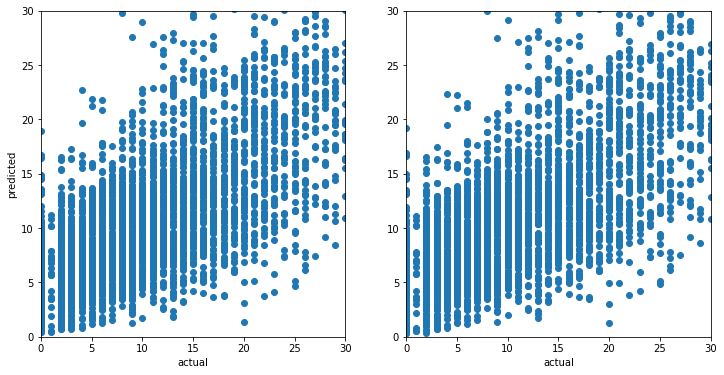

In [393]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
ax1.scatter(y_test, y_pred_lasso)
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')

ax2.scatter(y_test, y_pred_ridge)
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)
ax2.set_xlabel('actual')

In [350]:
pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)[:35]

FG_seasonAVG      2.357623
FGA_seasonAVG     1.161510
FT_seasonAVG      1.122424
FGA               0.983439
min               0.876542
3PA_seasonAVG     0.445042
TOV               0.241583
FTA_oppAVG        0.236197
FG                0.214733
DRB               0.195455
FT                0.169932
AST_oppAVG        0.131669
FT_Opp            0.123800
TOV_seasonAVG     0.120745
AST_Opp_oppAVG    0.096525
3PA_teamAVG       0.095931
+/-_seasonAVG     0.093386
FTA_Opp_oppAVG    0.077429
AST_Opp           0.073675
TRB_Opp_oppAVG    0.071422
BLK_Opp_oppAVG    0.068468
BLK_seasonAVG     0.056256
FGA_Opp           0.035535
FGA_Opp_oppAVG    0.032651
3P_Opp            0.030133
BLK               0.027003
STL_teamAVG       0.025458
STL               0.018250
TRB_oppAVG        0.017675
home_playerAVG    0.014158
3PA_Opp           0.007095
home_teamAVG      0.006462
FG_oppAVG         0.003964
home_seasonAVG    0.002935
score_Opp         0.000000
dtype: float64

The lasso regression zeros out all but 34 features to predict the number of points scored.  The most heavily weighted features include the player's season averages for field goals, field goal attempts, and free throw attempts.  The next most heavily weighted features are the player's field goal attempts and minutes played per game averaged over the last week.  Shockingly, the average points a player scored averaged over the whole season up until the game of interest had a value of 0, indicating that it was irrelevant for predicting points.  Meanwhile, that feature was the most important for the random forest regressor (see below).  It definitely seems like it would be a strong predictor of the number of points scored in a game. However, if you look at the plot below, there is high collinearity between points and field goals per game averaged over the season (intuitively makes sense).  Therefore, lasso regression likely reduced the weight of one of these to account for this collinearity.

(0.0, 14.0, 0.0, 40.0)

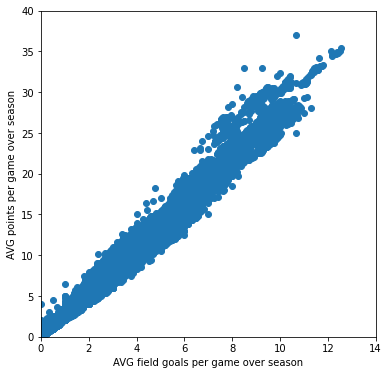

In [360]:
fig = plt.figure(figsize=(6,6))
plt.scatter(X['FG_seasonAVG'], X['PTS_seasonAVG'])
plt.xlabel('AVG field goals per game over season')
plt.ylabel('AVG points per game over season')
plt.axis([0, 14, 0, 40])

# SVR

In [250]:
from sklearn.svm import SVR

svr = SVR()
params = {'kernel': ['poly', 'rbf'],
          'gamma': ['scale', 'auto'],
          'C': [0.001, 0.01, 0.1, 1, 10, 100]
         }
grid = GridSearchCV(svr, param_grid=params, scoring='r2', cv=3)
grid.fit(X_train, y_train)
grid.best_estimator_

# best estimator is C=1, gamma='auto'

SVR score: 0.5047564762953427


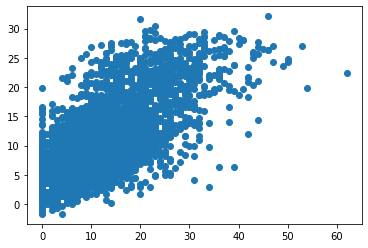

In [394]:
svr = SVR(C=1, gamma='auto', kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
_ = plt.scatter(y_test, y_pred)
y_score_svr = svr.score(X_test,y_test)
print('SVR score: {}'.format(y_score_svr))

# Random Forests

In [254]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor()

params = {'n_estimators': [100, 200, 300],
          'max_depth': [5, 7, 9, 11],
          'max_features': [10, 20, 30, 50]
         }

grid_tree = GridSearchCV(tree, param_grid=params, scoring='r2', cv=3)
grid_tree.fit(X_train, y_train)

print('Best RF params: {}'.format(grid_tree.best_estimator_))

Best RF params: RandomForestRegressor(max_depth=9, max_features=20, n_estimators=300)


RF score: 0.5378704146069041


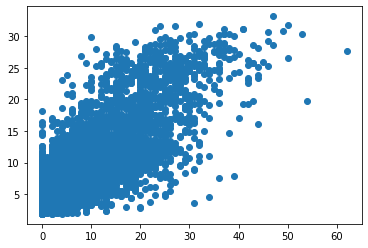

In [395]:
tree = RandomForestRegressor(max_depth=9, max_features=20, n_estimators=300)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_score_tree = tree.score(X_test,y_test)
print('RF score: {}'.format(y_score_tree))
_ = plt.scatter(y_test, y_pred_tree)

In [341]:
pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

PTS_seasonAVG     0.171200
FGA_seasonAVG     0.151848
FG_seasonAVG      0.119485
FGA               0.087062
PTS_playerAVG     0.062168
GmSc_seasonAVG    0.056702
FG                0.040072
min_seasonAVG     0.033060
FT_seasonAVG      0.028368
FTA_seasonAVG     0.025225
dtype: float64

The most important features to predict point scores according to the random forest regressor is the average number of points, field goal attempts, and field goals by a player averaged over the entire season up to the point of the game of interest.

# Voting Regressor

Voting Regressor score: 0.5348100828044844


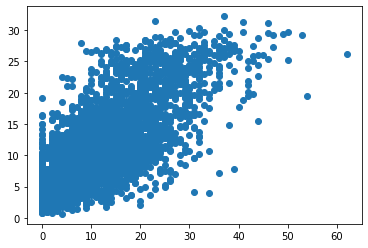

In [396]:
from sklearn.ensemble import VotingRegressor

weights = [y_score_ridge, y_score_lasso, y_score_svr, y_score_tree]
weights = weights / sum(weights)

vote = VotingRegressor([('Ridge',ridge), ('Lasso',lasso), ('SVR',svr), ('RF',tree)], weights=weights, n_jobs=-1)
vote.fit(X_train, y_train)
print('Voting Regressor score: {}'.format(vote.score(X_test,y_test)))
y_pred_vote = vote.predict(X_test)
_ = plt.scatter(y_test, y_pred_vote)

# create data to predict during NBA playoffs

In [405]:
def predict_player_points(player, team, opp, home, date):

    X_predict = pd.DataFrame(np.array([date, team, home, opp]).reshape(1,-1), columns = ['date', 'team', 'home', 'opp'])
    
    # add player stats averaged over the last week
    df_player = df_stats[df_stats['player'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_player_week = df_player_week.drop(columns=['player','date','team','opp']).mean()
    df_player_week = pd.DataFrame(np.array(df_player_week).reshape(1,-1), columns = df_player_week.index)

    # add player stats averaged over season up to this point
    df_player_season = df_player[df_player['date'] < date]
    df_player_season = df_player_season.drop(columns=['player','date','team','opp']).mean() 
    df_player_season = pd.DataFrame(np.array(df_player_season).reshape(1,-1), columns = df_player_season.index)

    # add team stats averaged over the last week
    df_team = teams_gamelog[team]
    df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_team_week = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
    df_team_week = pd.DataFrame(np.array(df_team_week).reshape(1,-1), columns = df_team_week.index)

    # add opponent stats averaged over the last week
    df_opp = teams_gamelog[opp]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_opp_week = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
    df_opp_week = pd.DataFrame(np.array(df_opp_week).reshape(1,-1), columns = df_opp_week.index)

    # merge all three df's
    X_predict = pd.merge(X_predict, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    X_predict = pd.merge(X_predict, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    X_predict = pd.merge(X_predict, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    X_predict = pd.merge(X_predict, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    X_predict.drop(columns=['date','team','opp'], axis=1, inplace=True)

    for col in X_predict.columns:
        if X_predict[col].isnull().sum() == len(X_predict):
            X_predict.drop(columns=[col], axis=1, inplace=True)

    X_predict = scale.transform(X_predict)
    y_pred = np.round(vote.predict(X_predict), 1)
    return y_pred[0]

## Predict one player 

In [406]:
player = '/b/bealbr01'
team = 'WAS'
opp = 'BOS'
home = 0
date = pd.to_datetime('2021-05-18')
predict_player_points(player, team, opp, home, date)

29.8

## Predict top three scorers in a game

In [422]:
team1 = 'WAS'
team2 = 'BOS'
home_team = 'BOS'
date = pd.to_datetime('today').normalize()

df_team1 = df_players[df_players['team'] == team1]
df_team2 = df_players[df_players['team'] == team2]

predictions = []

# team 1 predictions
team = team1
opp = team2
if team1 == home_team:
    home = 1
else:
    home = 0
for player in df_team1['player']:
    try:
        y_pred = predict_player_points(player, team, opp, home, date)
        predictions.append([team, player, y_pred])
    except:
        pass
    
# team 2 predictions
team = team2
opp = team1
if team2 == home_team:
    home = 1
else:
    home = 0
for player in df_team2['player']:
    try:
        y_pred = predict_player_points(player, team, opp, home, date)
        predictions.append([team, player, y_pred])
    except:
        pass
    
predictions = pd.DataFrame(predictions, columns=['team', 'player', 'prediction'])
predictions = predictions.sort_values(by='prediction', ascending=False)
top3 = predictions['prediction'].iloc[0] + predictions['prediction'].iloc[1] + predictions['prediction'].iloc[2]
print('Predicted point total of top 3 scorers: {}'.format(round(top3,1)))
print('Total game score: {}'.format(predictions['prediction'].sum()))
predictions.head()

Predicted point total of top 3 scorers: 81.0
Total game score: 288.29999999999995


,team,player,prediction
4,WAS,/b/bealbr01,29.8
14,BOS,/t/tatumja01,27.7
1,WAS,/w/westbru01,23.5
20,BOS,/w/walkeke02,22.4
26,BOS,/f/fournev01,17.3


# Betting
- Start with \$1,000
- At monkeyknifefight.com, you have to correctly guess the over/under for points scored by two players (one from each team in the game)
- The payout is typically 3x
    - Since you have to correctly predict two props to win the bet, I must be correct 33% of the time to come out even with a 3x payout.  This means that I must be correct 57.4% of the time for each individual prediction to come out even.  I can potentially reduce this further by betting larger amounts on bets that I am more confident in.
- Bet based on the following process:
    - determine the mean and standard deviation of the difference between actual and predicted points scored to get a normal distribution
    - determine the area under the cumulative distribution function for the difference between the over/under for a particular player and the model prediction
    - this area represents the probability that my prediction is correct
    - multiply this value times the value for the second player in the prop bet
    - if this value is greater than 0.33 (since I need to be correct at least 33% of the time for a 3x payout), make the bet based on the following formula:
        - if p > 0.33, bet = $800*p^4$
        - bet more money on bets with greater probability of success
    

95.0% confidence interval: [0.11 0.49]
Median: -0.4955409317937889
Mean: 0.30401797890527055
Standard Deviation: 6.158528808467588


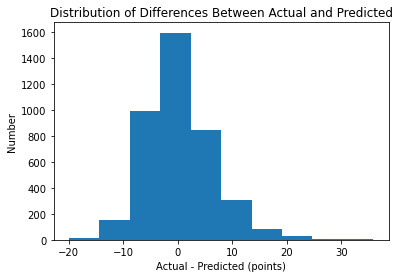

In [438]:
y_diff = y_test - y_pred_vote
_ = plt.hist(y_diff)
plt.xlabel('Actual - Predicted (points)')
plt.ylabel('Number')
plt.title('Distribution of Differences Between Actual and Predicted')

import scipy.stats as st
alpha = 0.95
CI = st.norm.interval(alpha=alpha, loc=np.mean(y_diff), scale=st.sem(y_diff))
print('{}% confidence interval: {}'.format(100*alpha, np.round(CI,2)))
std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
median = np.median(y_diff)
print('Median: {}'.format(median))
print('Mean: {}'.format(mean))
print('Standard Deviation: {}'.format(std))

In [472]:
diff1 = 1.5
diff2 = 1.5
p1 = st.norm(mean,std).cdf(diff1)
p2 = st.norm(mean,std).cdf(diff2)
p = p1 * p2
print('Probability of winning the bet: {}'.format(round(p,3)))
print('Probability of winning part 1: {}'.format(round(p1,3)))
print('Probability of winning part 2: {}'.format(round(p2,3)))
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0
print('Bet ${} on this prop'.format(bet))

Probability of winning the bet: 0.333
Probability of winning part 1: 0.577
Probability of winning part 2: 0.577
Bet $9.83 on this prop
